In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt

/home/rajiv/miniconda3/envs/mlenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [151]:
# CONFIGURATION
BATCH_SIZE = 128
TIME_STEPS = 1000
MID_STEPS = 200
BETA_START = 1e-4
BETA_END = 5e-3
LR_DDPM = 1e-4
LR_VAE = 1e-4

In [152]:
# Load dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [153]:
# Define diffusion model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
diffusion_model = UNet2DModel(sample_size=28, in_channels=1, out_channels=1, layers_per_block=2, 
    block_out_channels=[32, 64],  # Only 2 blocks
    down_block_types=("DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D")).to(device)
scheduler = DDPMScheduler(num_train_timesteps=TIME_STEPS)
scheduler = DDPMScheduler(num_train_timesteps=TIME_STEPS, beta_start=BETA_START, beta_end=BETA_END, beta_schedule="linear")
optimizer = optim.Adam(diffusion_model.parameters(), lr=LR_DDPM)

print("Expected UNet input size:", diffusion_model.config.sample_size)

Expected UNet input size: 28


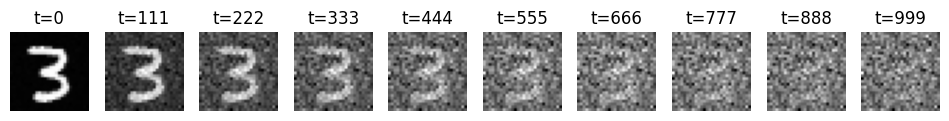

In [154]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_forward_process(dataloader, scheduler, device, num_intervals=4):
    x, _ = next(iter(dataloader))
    x = x.to(device)

    # Select a single image
    sample_idx = 0
    x_sample = x[sample_idx].unsqueeze(0)  # Shape: (1, 1, 28, 28)

    # Generate random noise
    noise = torch.randn_like(x_sample)
    timesteps = np.linspace(0, TIME_STEPS - 1, num_intervals, dtype=int)
    fig, axes = plt.subplots(1, len(timesteps), figsize=(12, 3))

    for i, t in enumerate(timesteps):
        timestep = torch.tensor([t], device=device)  # Single timestep
        noisy_x = scheduler.add_noise(x_sample, noise, timestep)  # Apply noise

        img = noisy_x.squeeze(0).squeeze(0).cpu().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"t={t}")
        axes[i].axis("off")

    plt.show()

show_forward_process(dataloader, scheduler, device, num_intervals=10)


In [112]:
print(device)

cuda


In [ ]:
import torch
import os
from tqdm import tqdm

# Directory to save/load checkpoints
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Function to load checkpoint
def load_checkpoint(diffusion_model, optimizer, checkpoint_path, device):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        diffusion_model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1  # Resume from next epoch
        print(f"Checkpoint loaded: {checkpoint_path} | Resuming from Epoch {start_epoch}")
        return start_epoch
    else:
        print(f"No checkpoint found at {checkpoint_path}, starting from scratch.")
        return 0  # Start from scratch if no checkpoint found

# Ask user for checkpoint path and epoch (Modify this if needed)
final_epoch = 5  # Default start from epoch 0
checkpoint_epoch = 0 # Example: set this to a specific epoch to resume from

if checkpoint_epoch != 0:
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"diffusion_epoch_{checkpoint_epoch}.pth")
    resume_epoch = load_checkpoint(diffusion_model, optimizer, checkpoint_path, device)

# Train diffusion model directly on image space
for epoch in range(checkpoint_epoch, final_epoch):  # Resume from loaded epoch
    epoch_loss = 0  # Track epoch loss
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")

    for i, (x, _) in enumerate(progress_bar):
        x = x.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, TIME_STEPS, (x.shape[0],), device=device)
        noisy_x = scheduler.add_noise(x, noise, timesteps)

        pred_noise = diffusion_model(noisy_x, timesteps).sample
        loss = ((pred_noise - noise) ** 2).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update loss tracking
        epoch_loss += loss.item()

        # Update tqdm progress bar with loss
        progress_bar.set_postfix(loss=f"{loss.item():.6f}")

    # Print epoch loss
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch} | Avg Loss: {avg_loss:.6f}")

    # Save model checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"diffusion_epoch_{epoch}.pth")
    torch.save({
        "epoch": epoch,
        "model_state_dict": diffusion_model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")


Epoch 0:   2%|▏         | 9/468 [00:01<01:28,  5.17it/s, loss=0.586712]

Generating Images: 1000it [00:05, 181.40it/s]


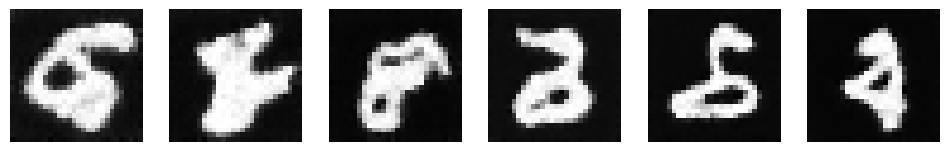

In [126]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def generate_samples(diffusion_model, scheduler, device, num_images=6, num_steps=TIME_STEPS):
    """
    Generates samples from the trained diffusion model by reversing the diffusion process.

    Args:
        diffusion_model: Trained U-Net diffusion model.
        scheduler: DDPMScheduler used for denoising.
        device: PyTorch device (cuda or cpu).
        num_images: Number of images to generate.
        num_steps: Number of diffusion steps (should match training config).
    """
    diffusion_model.eval()  # Set model to evaluation mode

    # Start with pure Gaussian noise
    img_shape = (num_images, 1, 28, 28)  # (batch, channels, height, width)
    samples = torch.randn(img_shape, device=device)

    # Generate images by reversing the diffusion process
    for t in tqdm(reversed(range(num_steps)), desc="Generating Images"):
        timestep = torch.tensor([t], device=device, dtype=torch.int64)  # Single timestep tensor

        with torch.no_grad():
            pred_noise = diffusion_model(samples, timestep).sample  # Predict noise

        # Denoise step
        samples = scheduler.step(model_output=pred_noise, timestep=timestep[0], sample=samples).prev_sample

    # Visualize generated samples
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        img = samples[i].squeeze(0).cpu().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].axis("off")

    plt.show()

# Call function to generate samples
generate_samples(diffusion_model, scheduler, device, num_images=6)


In [28]:
# # Train diffusion model
# for epoch in range(3):  # Small number of epochs for demonstration
#     for x, _ in dataloader:
#         print('xdim', x.shape)
#         x = x.to(device)
#         noise = torch.randn_like(x)
#         timesteps = torch.randint(0, 500, (x.shape[0],), device=device)
#         noisy_x = scheduler.add_noise(x, noise, timesteps)
#         print(noisy_x.shape, timesteps.dtype, noise.shape, noise.dtype)
#         pred_noise = diffusion_model(noisy_x, timesteps).sample
#         loss = ((pred_noise - noise) ** 2).mean()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

In [127]:
# Get diffusion steps output in the middle of forward process (say 20% steps)
def get_noised_images(x, timesteps=MID_STEPS):
    noise = torch.randn_like(x)
    return scheduler.add_noise(x, noise, torch.full((x.shape[0],), timesteps, device=device))

# Prepare dataset for VAE
vae_inputs, vae_targets = [], []
for x, _ in dataloader:
    x = x.to(device)
    vae_inputs.append(x)
    vae_targets.append(get_noised_images(x))
vae_inputs, vae_targets = torch.cat(vae_inputs), torch.cat(vae_targets)

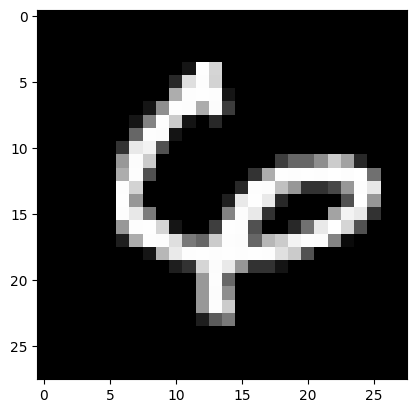

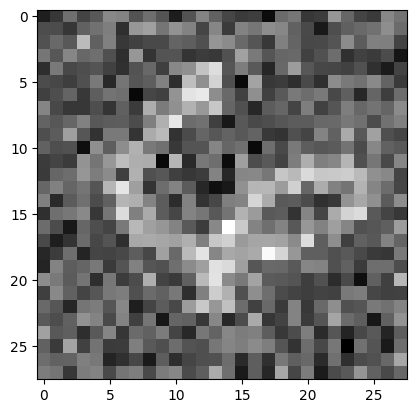

In [128]:
def show_img(inp):
    img = inp.squeeze(0).cpu().numpy() 
    plt.imshow(img, cmap="gray")
    plt.show()

show_img(vae_inputs[1])
show_img(vae_targets[1])

In [77]:
# Define simple VAE
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 128), nn.ReLU(), nn.Linear(128, 32))
        self.decoder = nn.Sequential(nn.Linear(32, 128), nn.ReLU(), nn.Linear(128, 28*28), nn.Unflatten(1, (1, 28, 28)))
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

vae = VAE().to(device)
vae_optimizer = optim.Adam(vae.parameters(), lr=LR_VAE)
loss_fn = nn.MSELoss()

# Train VAE
for epoch in range(10):
    print('epoch', epoch)
    for i in range(0, len(vae_inputs), 64):
        x_batch = vae_inputs[i:i+64].to(device)
        target_batch = vae_targets[i:i+64].to(device)
        output = vae(x_batch)
        loss = loss_fn(output, target_batch)
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()



epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [78]:
with torch.no_grad():
    latent_samples = torch.randn(16, 32, device=device)  # Sample from latent space

    latent_samples[0] = vae.encoder(vae_inputs[1]).flatten()
    latent_samples[1] = vae.encoder(vae_inputs[2]).flatten()
    latent_samples[2] = 0.5 * latent_samples[0] + 0.5*latent_samples[1]

In [79]:
# Sampling
with torch.no_grad():
    vae_output = vae.decoder(latent_samples)

    sampled = vae_output  # Start from D(x), which is the noisy image at t=100
    timesteps = list(range(MID_STEPS, -1, -1))  # Reverse diffusion from t=100 to t=0
    for t in timesteps:
        timestep = torch.full((sampled.shape[0],), t, device=device)
        noise_pred = diffusion_model(sampled, timestep).sample  # Predict noise
        sampled = scheduler.step(noise_pred, t, sampled).prev_sample  # Reverse diffusion step

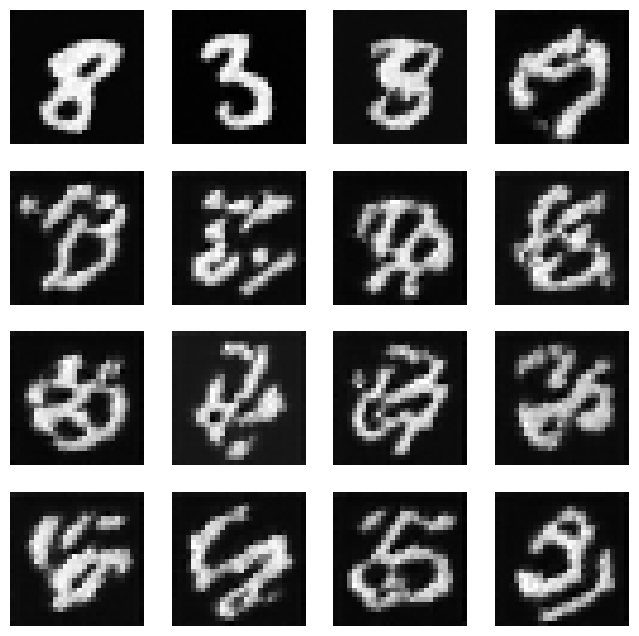

In [80]:
# samples = vae_xx_output_diffused.cpu().numpy().squeeze()  # Shape: (16, 28, 28)
samples = sampled.cpu().numpy().squeeze()  # Shape: (16, 28, 28)

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i], cmap="gray")
    ax.axis("off")  # Hide axis

plt.show()

In [35]:
# Blurring experiment